In [2]:
from pandas import read_csv, DataFrame
from numpy.random import seed
from sklearn.preprocessing import scale
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Dense, Merge
from keras.layers.normalization import BatchNormalization
from keras import initializers, layers
from keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# import ReadStandardTimeFill as RSTF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
seed(1)

def Footprint(Input,N):
    model = Sequential()
    model.add(Dense(N, input_shape = (Input.shape[1],), activation = 'sigmoid'))
    model.add(BatchNormalization())
    return(model)
    
def Weather(Input,N):
    model = Sequential()
    model.add(Dense(N, input_shape = (Input.shape[1],), activation = 'relu'))
    model.add(BatchNormalization())
    return(model)
    
def Concat(Inputs,N):
    model = Sequential()
    model.add(Merge(Inputs, mode = 'concat'))
    model.add(Dense(N, activation = 'relu'))#,kernel_initializer=initializer))
#     model.add(Dense(2))
    return(model)
    
def Compile(model):
    model.add(Dense(1))
    callbacks = [EarlyStopping(monitor='val_loss', patience=10)]
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model,callbacks)

class ReadStandardTimeFill:
    def __init__(self,Path):
        self.Master = pd.read_csv(Path,delimiter = ',',header = 0,na_values = -9999)
        self.Master = self.Master.set_index(pd.DatetimeIndex(pd.to_datetime(self.Master['datetime'])))
        self.Master['DOY'] = self.Master.index.dayofyear*1.0
        self.Master['HR'] = self.Master.index.hour*1.0
        self.Master['fch4'] *= 1000
        self.TimeSteps=0
        
    def Scale(self,y_var,X1_vars,X2_vars=[]):
        self.y_var = y_var
        self.Data = self.Master[np.isfinite(self.Master[y_var])]
        self.Data = self.Data.interpolate().bfill()
        self.Data = self.Data.interpolate().ffill()
        self.y = self.Data[y_var].values
        YStandard = StandardScaler()
        self.YScaled = YStandard.fit(self.y.reshape(-1, 1))
        Yscale = self.YScaled.transform(self.y.reshape(-1, 1))
        self.y = np.ndarray.flatten(Yscale)
        self.Ytru = self.YScaled.inverse_transform(self.y.reshape(-1,1))
        if len(X2_vars)>0:
            X1 = self.Data[X1_vars]
            X1Standard = StandardScaler()
            self.X1Scaled= X1Standard.fit(X1)
            self.X1 = self.X1Scaled.transform(X1)
            Filling1 = self.Master[X1_vars]
            Filling1 = Filling1.interpolate().bfill()
            Filling1 = Filling1.interpolate().ffill()
            self.X1FillScaled= X1Standard.fit(Filling1)
            self.X1_fill = self.X1Scaled.transform(Filling1)
            
            X2 = self.Data[X2_vars]
            X2Standard = StandardScaler()
            self.X2Scaled= X2Standard.fit(X2)
            self.X2 = self.X2Scaled.transform(X2)
            Filling2 = self.Master[X2_vars]
            Filling2 = Filling2.interpolate().bfill()
            Filling2 = Filling2.interpolate().ffill()
            self.X2FillScaled= X2Standard.fit(Filling2)
            self.X2_fill = self.X2Scaled.transform(Filling2)
        else:
            X = self.Data[X1_vars]
            self.input_shape = len(X1_vars)
            XStandard = StandardScaler()
            self.XScaled= XStandard.fit(X)
            self.X = self.XScaled.transform(X)
            Filling = self.Master[X1_vars]
            Filling = Filling.interpolate().bfill()
            Filling = Filling.interpolate().ffill()
#             XStandard = StandardScaler()
            self.XFillScaled= XStandard.fit(Filling)
            self.X_fill = self.XScaled.transform(Filling)
        
cwd = os.getcwd()
params={}
params['Dpath'] = cwd+'/Illisarvik/'
RST = ReadStandardTimeFill(params['Dpath']+'ECData.csv')

# RST = ReadStandardTimeFill()

In [28]:
fp_vars = ['Sedge','Grass','Shrub','Sparse','Water','Out_of_Basin']
# wx_vars = ['VWC','wind_speed', 'PPFD_Avg', 'VPD', 'AirTC_Avg','VWC','Temp']
wx_vars = ['wind_dir','wind_speed']
wx_var = ['VWC']
# wx_var = ['VWC','Sedge','Grass','Shrub','Sparse','Water','Out_of_Basin']
# print (fp_vars+wx_vars)
# RST.Scale('fch4',fp_vars,wx_vars)
RST.Scale('fch4',fp_vars,wx_vars)
# print(RST.X2)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Anaconda3\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '



0.36524578121941764 70.87627541197409

0.02949535466497244 121.28858259280887

0.11512355603757252 93.33615457738543

0.29217187511718024 65.60468315864725

0.5753385299427474 71.57121554940859


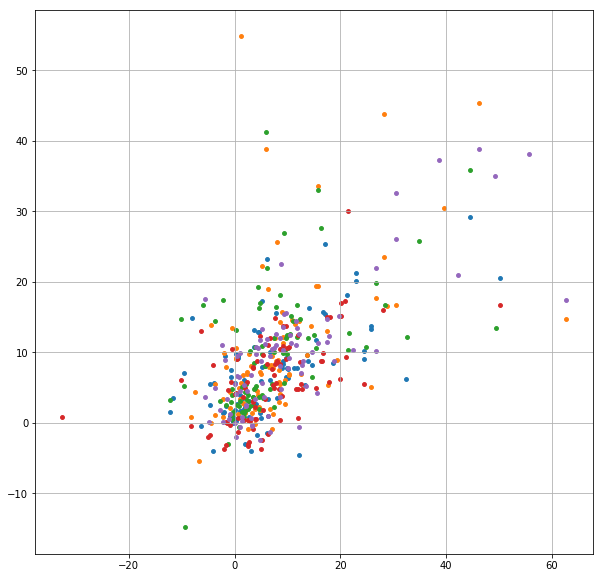

(1338, 1)
84.53538225804485


In [29]:

from sklearn.model_selection import train_test_split
plt.figure(figsize=(10,10))
Score = []
nCap=30#5
Avgz=[]
# Valz = []
for i in range(5):
    seed(i)
    X1_train,X1_test,X2_train,X2_test,y_train,y_test=train_test_split(RST.X1,RST.X2,RST.y, test_size=0.1)
    X1_train,X1_val,X2_train,X2_val,y_train,y_val=train_test_split(X1_train,X2_train,y_train, test_size=0.11)

    Fp = Footprint(X1_train,N=X1_train.shape[1]*nCap)
    Wt = Weather(X2_train,N=X2_train.shape[1]*nCap)
    
    FullModel = Concat([Fp,Wt],N=X1_train.shape[1]*nCap+X2_train.shape[1]*nCap)
    FullModel,callbacks = Compile(FullModel)
    FullModel.fit([X1_train,X2_train], y_train,
                  validation_data=([X1_test,X2_test], y_test), 
                  batch_size = 50, nb_epoch = 1000,
                  verbose = 0,callbacks=callbacks)
    Yp = FullModel.predict([X1_val,X2_val],batch_size=100)
    Avgz.append(RST.YScaled.inverse_transform(FullModel.predict([RST.X1_fill,RST.X2_fill],batch_size=100).reshape(-1,1)))

#     X_train = X2_train
#     X_test = X2_test
#     X_val = X2_val
#     X_fill = RST.X2_fill
#     FullModel,callbacks = Compile(Wt)
#     FullModel.fit(X_train, y_train,
#                   validation_data=(X_test, y_test), 
#                   batch_size = 50, nb_epoch = 1000,
#                   verbose = 0,callbacks=callbacks)
#     Yp = FullModel.predict(X_val,batch_size=100)
#     Avgz.append(RST.YScaled.inverse_transform(FullModel.predict(X_fill,batch_size=100).reshape(-1,1)))
    

    Yp = RST.YScaled.inverse_transform(Yp.reshape(-1,1))
    Yv = RST.YScaled.inverse_transform(y_val.reshape(-1,1))
    print()
    print(metrics.r2_score(Yv,Yp),metrics.mean_squared_error(Yv,Yp))
    Score.append(metrics.mean_squared_error(Yv,Yp))
    plt.scatter(Yv,Yp,s=15,label = 'Concated')
    
    
    
    
# plt.xlim(-20,80)
# plt.ylim(-20,80)
plt.grid()
plt.show()
Avgz=np.asanyarray(Avgz).mean(axis=0)#axis=-1)
print(Avgz.shape)

MSE = np.asanyarray(Score)
print(MSE.mean())

#old 34.37323956423951

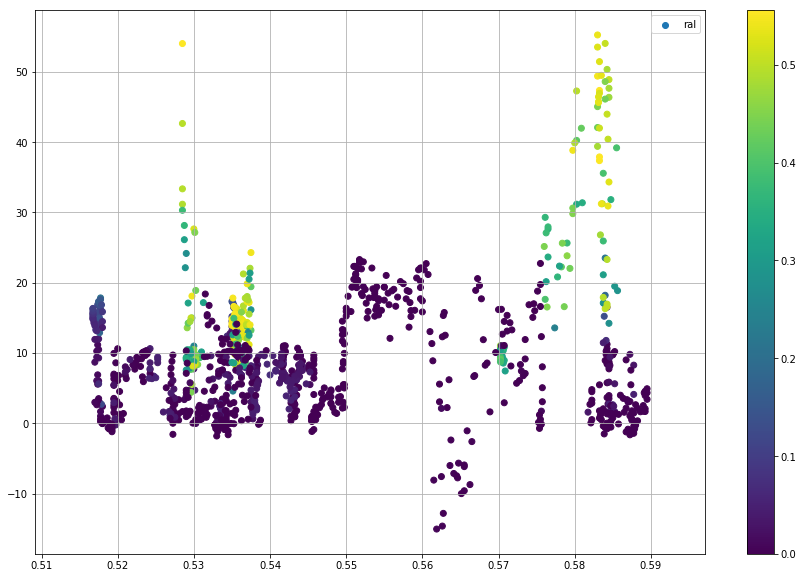

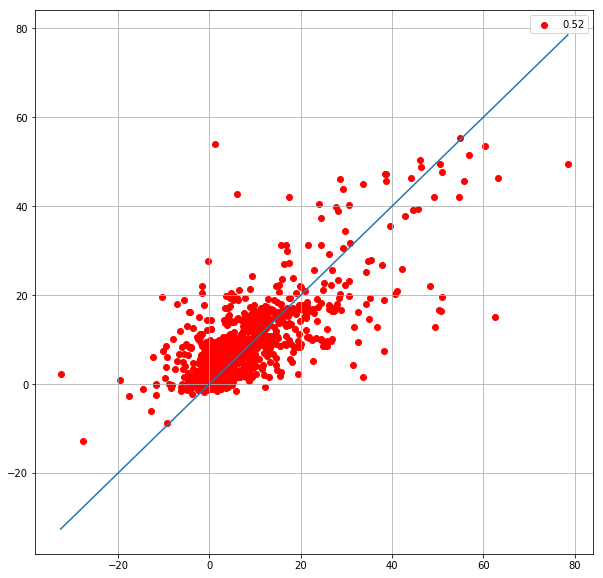

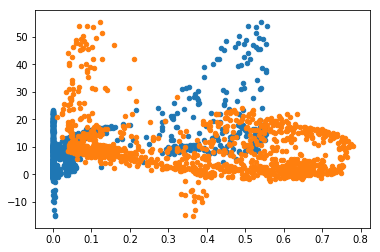

In [30]:

RST.Master['Fill'] = Avgz

plt.figure(figsize=(15,10))
# plt.plot(Avgz[1])
c = plt.scatter(RST.Master['VWC'],RST.Master['Fill'],c=RST.Master['Sedge'],label='ral')
# plt.scatter(RST.Master['fch4'].values,RST.Master['VWC'].values,c='K')#RST.Master['Sedge'].values,label='ral')
# plt.plot(Avgz,label='fak',color='red')
plt.colorbar()
# plt.plot()
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10,10))
# plt.plot(Avgz[1])
Temp = RST.Master[['fch4','Fill']].dropna()
plt.scatter(RST.Master['fch4'].values,Avgz,
            label=str(np.round(metrics.r2_score(Temp['fch4'],Temp['Fill']),2)),
            color='red')
plt.plot([Temp['fch4'].min(),Temp['fch4'].max()],[Temp['fch4'].min(),Temp['fch4'].max()])
plt.legend()

plt.grid()
plt.show()

plt.figure()
plt.scatter(RST.Master['Sedge'],RST.Master['Fill'],s=20)
plt.scatter(RST.Master['Grass'],RST.Master['Fill'],s=20)
# plt.scatter(RST.Master['Fill'],RST.Master['Grass'])
# plt.scatter(RST.Master['Fill'],RST.Master['Shrub'])
plt.show()

# print(RST.Master.loc[np.isnan(RST.Master['Sedge'])==True,['wind_speed']])
# print(RST.Master.loc[(RST.Master.index >= '2016-07-15 12:00:00')&(RST.Master.index <= '2016-07-16 13:00:00'),
#                      ['Sedge','wind_speed']])

# plt.figure()
# plt.scatter(RST.Master['AirTC_Avg'],RST.Master['Sedge'],c=RST.Master['wind_speed'])
# plt.show()
# print(Avgz)
